In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab

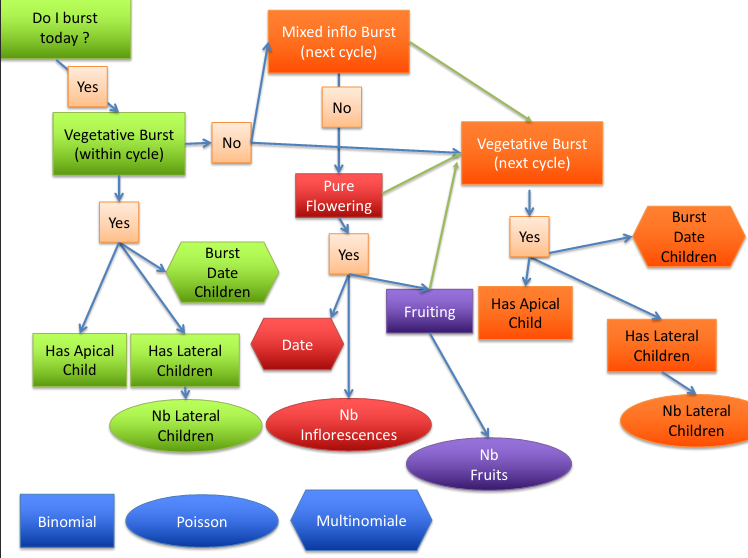

In [2]:
from IPython.display import Image
Image('growth.png')

In [3]:
import igraph as ig
import xsimlab as xs
import numpy as np
import pandas as pd

from vmlab.processes.architectural_development import (
    topology,
    has_veg_children_within,
    has_apical_child_within,
    burst_date_children_within,
    has_lateral_children_within,
    nb_lateral_children_within,
    has_mixed_inflo_children_between,
    has_veg_children_between,
    has_apical_child_between,
    burst_date_children_between,
    has_lateral_children_between,
    nb_lateral_children_between,
    flowering,
    flowering_week,
    nb_inflorescences,
    fruiting,
    nb_fruits,
    arch_dev
)


In [4]:
model = xs.Model({
    'topology': topology.Topology,
    'has_veg_children_within': has_veg_children_within.HasVegChildrenWithin,
    'has_apical_child_within': has_apical_child_within.HasApicalChildWithin,
    'burst_date_children_within': burst_date_children_within.BurstDateChildrenWithin,
    'has_lateral_children_within': has_lateral_children_within.HasLateralChildrenWithin,
    'nb_lateral_children_within': nb_lateral_children_within.NbLateralChildrenWithin,
    'has_mixed_inflo_children_between': has_mixed_inflo_children_between.HasMixedInfloChildrenBetween,
    'has_apical_child_between': has_apical_child_between.HasApicalChildBetween,
    'burst_date_children_between': burst_date_children_between.BurstDateChildrenBetween,
    'has_lateral_children_between': has_lateral_children_between.HasLateralChildrenBetween,
    'nb_lateral_children_between': nb_lateral_children_between.NbLateralChildrenBetween,
    'flowering': flowering.Flowering,
    'flowering_week': flowering_week.FloweringWeek,
    'nb_inflorescences': nb_inflorescences.NbInflorescences,
    'fruiting': fruiting.Fruiting,
    'nb_fruits': nb_fruits.NbFruits,
    'has_veg_children_between': has_veg_children_between.HasVegChildrenBetween,
    'arch_dev': arch_dev.ArchDev
})

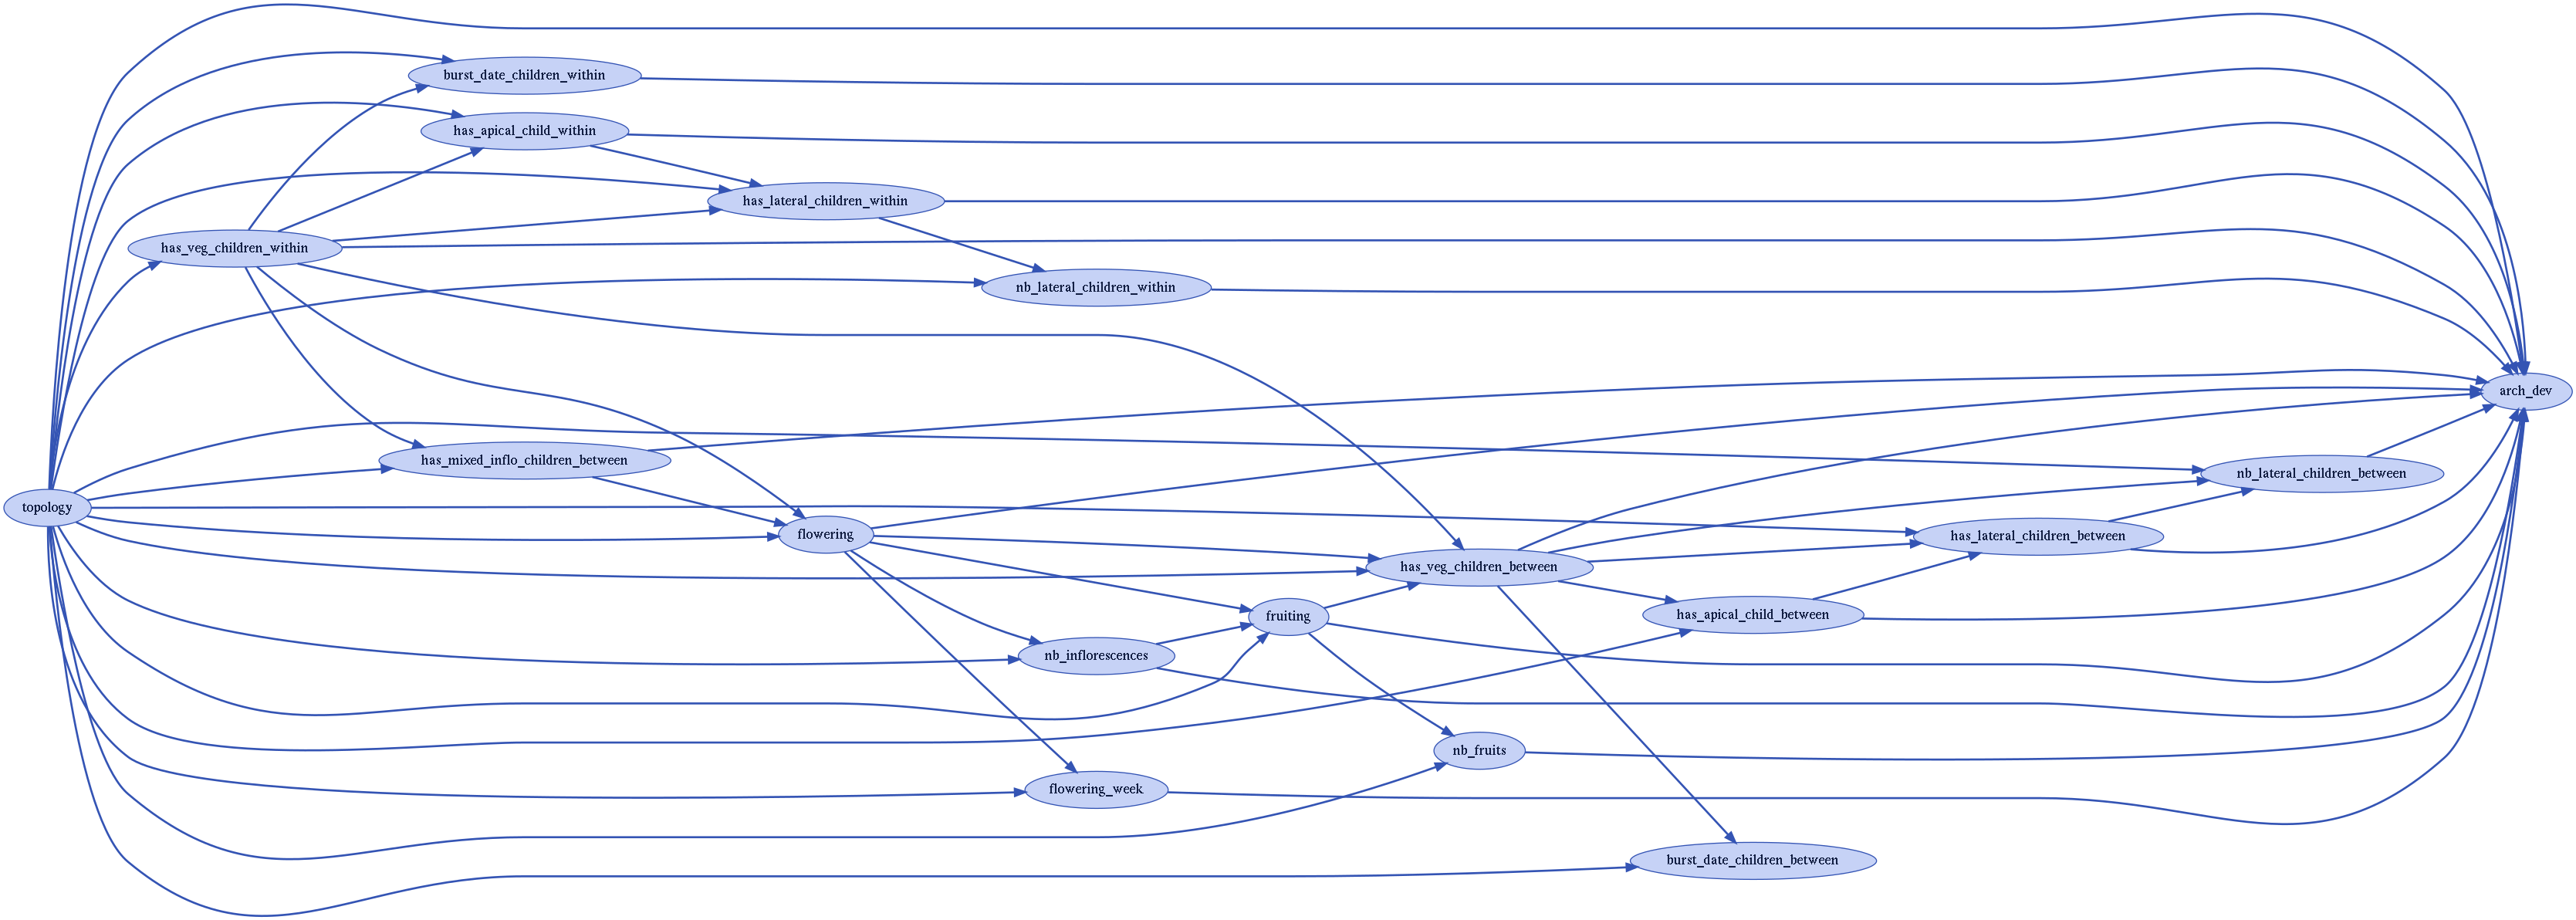

In [5]:
model.visualize(show_variables=False)

In [6]:
clock = pd.date_range(start='2002-08-01', end='2004-09-01', freq="MS")
ds = xs.create_setup(
    model=model,
    clocks={
        'month': clock
    },
    input_vars={
        'topology': {
            'seed': 123,
            'current_cycle': 4,
            'is_start_of_cycle': (clock.month == 7)
        },
        'has_veg_children_within__path': '../share/probability_tables/interaction_glm/has_veg_children_within',
        'has_apical_child_within__path': '../share/probability_tables/interaction_glm/has_apical_child_within',
        'burst_date_children_within__path': '../share/probability_tables/interaction_glm/burst_date_children_within',
        'has_lateral_children_within__path': '../share/probability_tables/interaction_glm/has_lateral_children_within',
        'nb_lateral_children_within__path': '../share/probability_tables/interaction_glm/nb_lateral_children_within',
        
        'has_mixed_inflo_children_between__path': '../share/probability_tables/interaction_glm/has_mixed_inflo_children_between', 
        
        'has_veg_children_between__path': '../share/probability_tables/interaction_glm/has_veg_children_between',
        'has_apical_child_between__path': '../share/probability_tables/interaction_glm/has_apical_child_between',
        'burst_date_children_between__path': '../share/probability_tables/interaction_glm/burst_date_children_between',
        'has_lateral_children_between__path': '../share/probability_tables/interaction_glm/has_lateral_children_between',
        'nb_lateral_children_between__path': '../share/probability_tables/interaction_glm/nb_lateral_children_between',
        
        'flowering__path': '../share/probability_tables/interaction_glm/flowering',
        'flowering_week__path': '../share/probability_tables/interaction_glm/flowering_week',
        'nb_inflorescences__path': '../share/probability_tables/interaction_glm/nb_inflorescences',
        'fruiting__path': '../share/probability_tables/interaction_glm/fruiting',
        'nb_fruits__path': '../share/probability_tables/interaction_glm/nb_fruits',
        'arch_dev': {
            'burst_date': np.array(['2002-09-01'], dtype='datetime64[D]'),
            'has_apical_child': np.array([1.]),
            'nb_lateral_children': np.array([2.]),
            'nature': np.array([0.])
        }
    },
    output_vars={
        'topology': {
            'adjacency': None,
            'position': None,
            'cycle': None,
            'appeared': 'month',
            'current_cycle': 'month',
            'appearance_date': None
        },
        'arch_dev': {
            'burst_date': None,
            'has_apical_child': None,
            'nb_lateral_children': None,
            'nature': None
        },
        'has_veg_children_within': {
            'has_veg_children_within': None
        },
        'has_apical_child_within': {
            'has_apical_child_within': 'month'
        },
        'burst_date_children_within': {
            'burst_date_children_within': 'month'
        },
        'has_lateral_children_within': {
            'has_lateral_children_within': 'month'
        },
        'nb_lateral_children_within': {
            'nb_lateral_children_within': 'month'
        },
    }
)

In [7]:
ds_out = ds.xsimlab.run(model, decoding={ 'mask_and_scale': False })
ds_out

<xarray.Dataset>
Dimensions:                                                   (GU: 14, month: 26)
Coordinates:
  * GU                                                        (GU) <U4 'GU0' ...
  * month                                                     (month) datetime64[ns] ...
Data variables:
    arch_dev__burst_date                                      (GU) datetime64[D] ...
    arch_dev__has_apical_child                                (GU) float64 1....
    arch_dev__nature                                          (GU) float64 0....
    arch_dev__nb_lateral_children                             (GU) float64 2....
    burst_date_children_between__path                         <U71 '../share/...
    burst_date_children_within__burst_date_children_within    (month, GU) datetime64[D] ...
    burst_date_children_within__path                          <U70 '../share/...
    flowering__path                                           <U53 '../share/...
    flowering_week__path                                      <U58 '../share/...
    fruiting__path                                            <U52 '../share/...
    has_apical_child_between__path                            <U68 '../share/...
    has_apical_child_within__has_apical_child_within          (month, GU) float64 ...
    has_apical_child_within__path                             <U67 '../share/...
    has_lateral_children_between__path                        <U72 '../share/...
    has_lateral_children_within__has_lateral_children_within  (month, GU) float64 ...
    has_lateral_children_within__path                         <U71 '../share/...
    has_mixed_inflo_children_between__path                    <U76 '../share/...
    has_veg_children_between__path                            <U68 '../share/...
    has_veg_children_within__has_veg_children_within          (GU) float64 0....
    has_veg_children_within__path                             <U67 '../share/...
    nb_fruits__path                                           <U53 '../share/...
    nb_inflorescences__path                                   <U61 '../share/...
    nb_lateral_children_between__path                         <U71 '../share/...
    nb_lateral_children_within__nb_lateral_children_within    (month, GU) float64 ...
    nb_lateral_children_within__path                          <U70 '../share/...
    topology__adjacency                                       (GU, GU) float64 ...
    topology__appearance_date                                 (GU) datetime64[D] ...
    topology__appeared                                        (month, GU) float64 ...
    topology__current_cycle                                   (month) int64 4...
    topology__cycle                                           (GU) float64 4....
    topology__is_start_of_cycle                               (month) bool Fa...
    topology__position                                        (GU) float64 1....
    topology__seed                                            int64 123

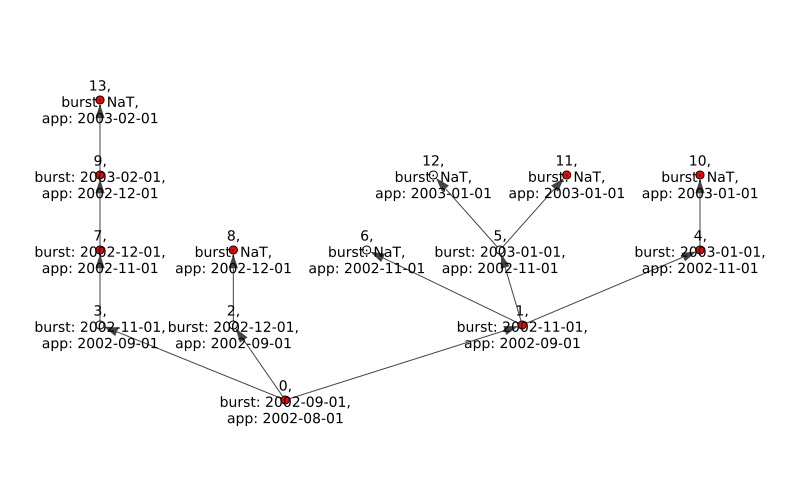

In [8]:
g = ig.Graph.Adjacency(list(ds_out.topology__adjacency.data))
layout = g.layout_reingold_tilford(root=0)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(800, 500), margin=(100, 100, 100, 100), **{
    'vertex_size': 8,
    'vertex_color': ['red' if is_apical else 'white' for is_apical in ds_out.topology__position],
    'vertex_label': [f'{idx}, \nburst: {ds_out.arch_dev__burst_date.data[idx]}, \napp: {ds_out.topology__appearance_date.data[idx].item().isoformat()}' for idx in g.vs.indices]
})